# Transfer Learning with TensorFlow
# Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neuratl network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading Data

In [68]:
import os

for dirpath, dirname, filenames in os.walk("10_food_classes_10_percent"):
    print( f" In {dirpath}, directories {len(dirname)}, and images {len(filenames)}")


 In 10_food_classes_10_percent, directories 2, and images 0
 In 10_food_classes_10_percent\test, directories 10, and images 0
 In 10_food_classes_10_percent\test\chicken_curry, directories 0, and images 250
 In 10_food_classes_10_percent\test\chicken_wings, directories 0, and images 250
 In 10_food_classes_10_percent\test\fried_rice, directories 0, and images 250
 In 10_food_classes_10_percent\test\grilled_salmon, directories 0, and images 250
 In 10_food_classes_10_percent\test\hamburger, directories 0, and images 250
 In 10_food_classes_10_percent\test\ice_cream, directories 0, and images 250
 In 10_food_classes_10_percent\test\pizza, directories 0, and images 250
 In 10_food_classes_10_percent\test\ramen, directories 0, and images 250
 In 10_food_classes_10_percent\test\steak, directories 0, and images 250
 In 10_food_classes_10_percent\test\sushi, directories 0, and images 250
 In 10_food_classes_10_percent\train, directories 10, and images 0
 In 10_food_classes_10_percent\train\ch

# Create data loaders (preparing the data)

In [69]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Setting up **callbacks** (things to run whilst our model trains)

**Callbacks** are extra functionality you can add to your model to be performed during or after training.

Some of the most popular **callbacks**:
* Tracking experiments with the **TensorBoard** callback
* Model checkpoint with the **ModelCheckpoint** callback
* Stopping a model from training (before it trains too long and overfits) with the **EarlyStopping** callback

In [70]:
# Create TensorBoard callback
import datetime


def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = (
        dir_name
        + "/"
        + experiment_name
        + "/"
        + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


# Creating models using TensorFlow Hub

Access pretrained models on: https://tfhub.dev/

In [71]:
# Compare 2 models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [72]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [73]:
def create_model(model_url, num_classes=10):
    """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): The URL of the model
        num_classes (int, optional): The number of classes in the dataset. Defaults to 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer
        and Dense output layer with num_classes output neurons.
    """
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name="feature-extractor-layer",
        input_shape=(IMAGE_SHAPE + (3,)),
    )

    model = tf.keras.Sequential()
    model.add(feature_extractor_layer)
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax", name="output-layer"))

    return model


## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [74]:
# Create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_generator.num_classes)


In [75]:
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)


In [76]:
resnet_history = resnet_model.fit(
    train_generator,
    batch_size=32,
    epochs=20,
    steps_per_epoch=len(train_generator),
    callbacks=[
        create_tensorboard_callback(
            dir_name="tensorflow_hub", experiment_name="Resnet50V2"
        )
    ],
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator),
)


Saving TensorBoard log files to: tensorflow_hub/Resnet50V2/20210812-122752
Epoch 1/20
24/24 [==============================] - 26s 904ms/step - loss: 2.0437 - accuracy: 0.3320 - val_loss: 1.2949 - val_accuracy: 0.5764
Epoch 2/20
24/24 [==============================] - 19s 814ms/step - loss: 1.0751 - accuracy: 0.6453 - val_loss: 0.8542 - val_accuracy: 0.7340
Epoch 3/20
24/24 [==============================] - 19s 823ms/step - loss: 0.7547 - accuracy: 0.7707 - val_loss: 0.7802 - val_accuracy: 0.7480
Epoch 4/20
24/24 [==============================] - 19s 817ms/step - loss: 0.6248 - accuracy: 0.8120 - val_loss: 0.7111 - val_accuracy: 0.7720
Epoch 5/20
24/24 [==============================] - 19s 809ms/step - loss: 0.5214 - accuracy: 0.8493 - val_loss: 0.6681 - val_accuracy: 0.7780
Epoch 6/20
24/24 [==============================] - 19s 808ms/step - loss: 0.4727 - accuracy: 0.8613 - val_loss: 0.6455 - val_accuracy: 0.7844
Epoch 7/20
24/24 [==============================] - 20s 828ms/step 

In [77]:
resnet_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature-extractor-layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output-layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [84]:
import matplotlib.pyplot as plt

def plot_loss_and_acc(model_name):
    plt.plot(model_name.history['loss'])
    plt.plot(model_name.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["loss", "val_loss"])
    plt.title("Loss")

    plt.figure()
    plt.plot(model_name.history['accuracy'])
    plt.plot(model_name.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["accuracy", "val_accuracy"])
    plt.title("Accuracy")


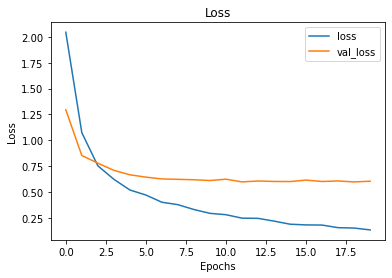

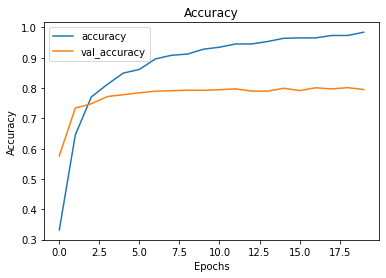

In [85]:
plot_loss_and_acc(resnet_history)

## Creating and testing EfficientNet TensorFlow Hub Feature Extraction model

In [86]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_generator.num_classes)


In [87]:
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [ ]:
efficientnet_history = efficientnet_model.fit(
    train_generator,
    batch_size=32,
    epochs=20,
    steps_per_epoch=len(train_generator),
    callbacks=[
        create_tensorboard_callback(
            dir_name="tensorflow_hub", experiment_name="EfficientNet"
        )
    ],
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator),
)

In [ ]:
plot_loss_and_acc(efficientnet_history)

In [ ]:
plot_loss_and_acc(resnet_history)